In [22]:
import os
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from yellowbrick.target import FeatureCorrelation
from yellowbrick.target import ClassBalance
from yellowbrick.features import Rank1D, Rank2D
from yellowbrick.features import Manifold
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.features import PCA
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.model_selection import RFECV


from tests.eda import plot_prop_x_prop
from src.datamanager.dataset_manager import FeaturesManager

np.random.seed(171)

Load data

In [23]:
pos_fasta = '../data/raw-data/fasta/Bacillus_pos.fa'
neg_fasta = '../data/raw-data/fasta/Bacillus_neg.fa'

In [30]:
with open(os.path.join('..', 'params', 'exp-test-eda.yaml')) as f:
    args_data = yaml.load(f, Loader=SafeLoader)
    print(args_data)
    print(args_data['features'][0])

{'experiment_name': 'EDA-01', 'experiment_version': 'v0.0.1', 'experiment_type': 'GradientBoostingExp', 'cv': 5, 'n_samples': 1, 'debug': 1, 'dataset_organism': 'Bacillus', 'datasets': [{'class_name': 'promoter', 'path': 'data/raw-data/fasta/Bacillus_pos.fa'}, {'class_name': 'non-promoter', 'path': 'data/raw-data/fasta/Bacillus_neg.fa'}], 'features': [{'k': 2, 'encode': 'prop', 'slice': [59, 20, 20]}], 'models_params': [{'model_name': 'GradientBoostingClassifier', 'module': 'sklearn.ensemble', 'params': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 1, 'random_state': 0}}]}
{'k': 2, 'encode': 'prop', 'slice': [59, 20, 20]}


In [25]:
dm = FeaturesManager(fasta_paths=(pos_fasta, neg_fasta))
dm.transform_raw_dataset(params=args_data['features'])

prop = 1
pos_data = pd.DataFrame(dm.datasets[0].encoded_classes_datasets[0][prop])
neg_data = pd.DataFrame(dm.datasets[0].encoded_classes_datasets[1][prop])
print(f'POS: {pos_data.shape} | NEG: {neg_data.shape}')

POS: (373, 40) | NEG: (1000, 40)


[<AxesSubplot: > <AxesSubplot: >]


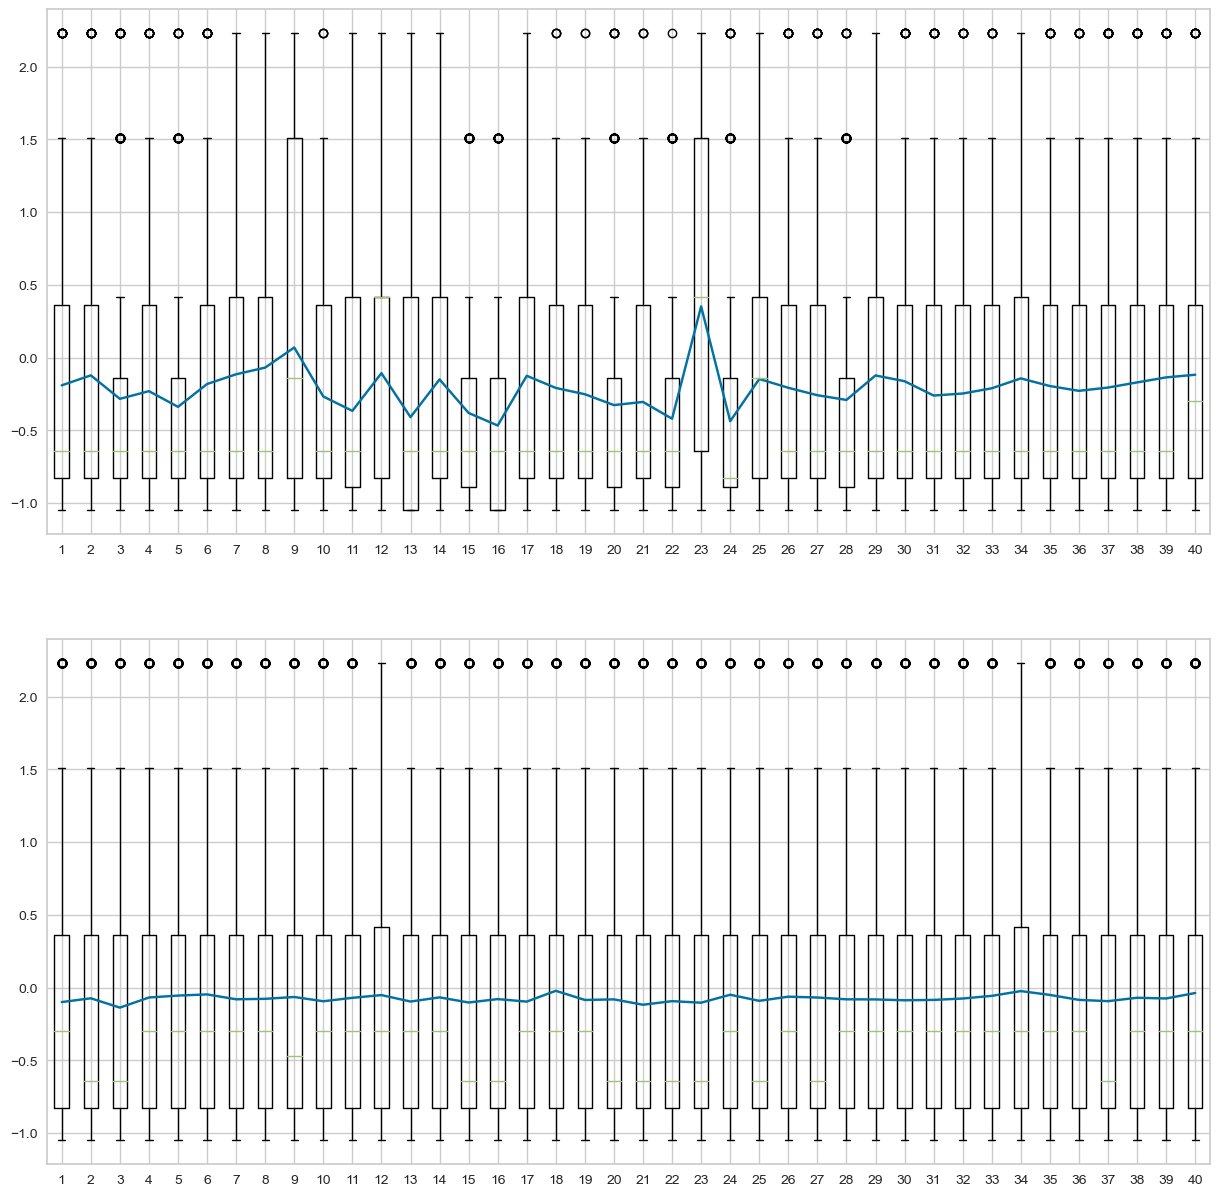

In [26]:
fig, ax = plt.subplots(2)
fig.set_figwidth(15)
fig.set_figheight(15)
print(ax)
ax[0].boxplot(pos_data)
ticks = ax[0].get_xticks()
ax[0].plot(ticks, pos_data.mean())
ax[1].boxplot(neg_data)
ticks = ax[1].get_xticks()
ax[1].plot(ticks, neg_data.mean())
plt.show()

In [27]:
X = pd.DataFrame(np.vstack([pos_data, neg_data]))
y = np.zeros(len(X))
y[len(pos_data):] += 1

In [28]:
# Remove a position
pos = 5
X.drop(pos, axis=1).shape

(1373, 39)

In [29]:
model = GradientBoostingClassifier(random_state=237)
n_cv = 5
vals = list()
for i in range(40):
    scores = cross_val_score(model, X.drop(i, axis=1), y, cv=n_cv)
    mean_score = np.mean(scores)
    vals.append(mean_score)
    print(f'MEAN:{mean_score} | POS DROPED: {i}')
plt.plot(vals)

MEAN:0.886415394824154 | POS DROPED: 0
MEAN:0.8878699402786994 | POS DROPED: 1
MEAN:0.8827790311877903 | POS DROPED: 2
MEAN:0.8886051758460518 | POS DROPED: 3
MEAN:0.8784074319840744 | POS DROPED: 4
MEAN:0.8842309223623092 | POS DROPED: 5
MEAN:0.8864207033842069 | POS DROPED: 6
MEAN:0.8791373589913736 | POS DROPED: 7
MEAN:0.8820464499004645 | POS DROPED: 8
MEAN:0.8827737226277372 | POS DROPED: 9
MEAN:0.8842309223623092 | POS DROPED: 10
MEAN:0.8754983410749834 | POS DROPED: 11
MEAN:0.8835063039150631 | POS DROPED: 12
MEAN:0.8725865958858661 | POS DROPED: 13
MEAN:0.8784127405441273 | POS DROPED: 14
MEAN:0.8791506303915062 | POS DROPED: 15
MEAN:0.8805998672859985 | POS DROPED: 16
MEAN:0.8871373589913736 | POS DROPED: 17
MEAN:0.8849688122096883 | POS DROPED: 18
MEAN:0.8857013934970139 | POS DROPED: 19
MEAN:0.8835063039150629 | POS DROPED: 20
MEAN:0.8820570670205707 | POS DROPED: 21
MEAN:0.8835009953550099 | POS DROPED: 22
MEAN:0.8806078301260782 | POS DROPED: 23
MEAN:0.8878805573988056 | P

KeyboardInterrupt: 

In [ ]:
classes = ["promoter", "non-promoter"]
# Instantiate the visualizer
visualizer = ClassBalance(labels=classes)

visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
# Create a list of the feature names
features = np.array(X.columns)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
# Instantiate the 1D visualizer with the Shapiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Finalize and render the figure

In [ ]:
# Instantiate the visualizer with the covariance ranking algorithm
visualizer = Rank2D(algorithm='covariance')

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Finalize and render the figure

In [ ]:
# Instantiate the visualizer
_y = LabelEncoder().fit_transform(y)
viz = Manifold(manifold="tsne", classes=classes)
viz.fit_transform(X, _y)  # Fit the data to the visualizer
viz.show()               # Finalize and render the figure

In [ ]:
# Create a pipeline
model = Pipeline([
    ("selectk", SelectKBest(k=10, score_func=f_classif)),
    ("viz", Manifold(manifold="isomap", n_neighbors=5, classes=classes)),
])

model.fit_transform(X, _y)          # Fit the data to the model
model.named_steps['viz'].show()   # Finalize and render the figure

In [ ]:
visualizer = PCA(
    scale=True, projection=3, classes=classes
)
visualizer.fit_transform(X, _y)
visualizer.show()

In [ ]:
# Perform 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=42, shuffle=True)
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    GradientBoostingClassifier(random_state=237, n_estimators=500), classes=classes
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

In [ ]:
model = GradientBoostingClassifier(random_state=237, n_estimators=500)
visualizer = ROCAUC(model, classes=classes)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [ ]:
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [ ]:
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

In [ ]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=classes)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

In [ ]:
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show()

In [ ]:
cv = StratifiedKFold(5)
# Instantiate RFECV visualizer with a classifier
visualizer = RFECV(model, scoring='f1_weighted')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure